# RFM Analysis

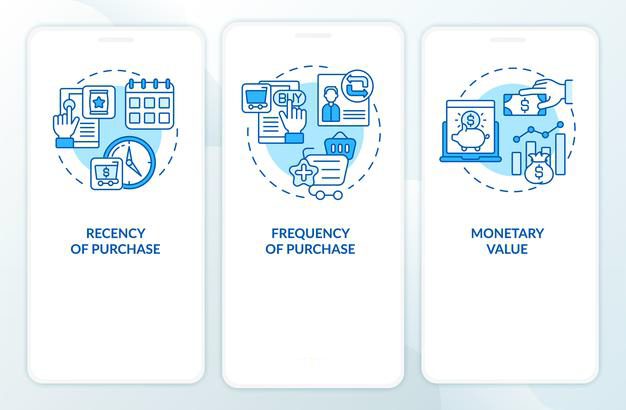

In [ ]:
# importing libraries
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)  # tüm sütunları gösterir
# pd.set_option('display.max_rows', None) # tüm satırları gösterir
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # numeric değerleri float virgülden sonra 4 hane gösterir

In [ ]:
pip install xlrd==1.2.0 

In [ ]:
pip install openpyxl


In [ ]:
# reading the data

df_ = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

In [ ]:
df.head()

In [ ]:


df.info()


In [ ]:

# descriptive statistics info
df.describe().T


In [ ]:
# empty value checking
df.isnull().sum()

In [ ]:
# re-check 
df.isnull().sum()

In [ ]:
# unique values count

df["StockCode"].nunique()

In [ ]:

df.groupby('StockCode').agg({'Quantity': "sum"})


In [ ]:
# top 5 product after sorting
df.groupby('StockCode').agg({'Quantity': "sum"}).sort_values(by="Quantity", ascending=False).head(5)


In [ ]:
# right now the returned good invoices still in dataframe but we have to discard them

df = df[~df["Invoice"].str.contains("C", na=False)]  

In [ ]:
# new observation for RFM metrics calculation
df["TotalPrice"] = df["Price"] * df["Quantity"]

In [ ]:
df.groupby("Invoice").agg({"TotalPrice": "sum"})

# RFM metrics calculation 
### Recency   = Shows how many days have passed since the last invoice
### Frequency = Count of how many times they buy
### Monetary  = monetary value

In [ ]:

today_date = dt.datetime(2011, 12, 11) 

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda total: total.sum()})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0]

In [ ]:
# normalise the data from 1 to 5 
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str) +
                    rfm['monetary_score'].astype(str)).astype(int)

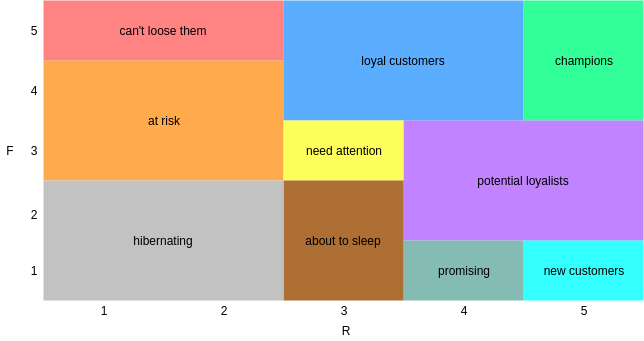   
this photo shows us  the classification of RM (Recency nd Monetary) metrics


In [ ]:
# classification map
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

In [ ]:

rfm['segment'] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)).replace(seg_map, regex=True)

In [ ]:
rfm.head()

In [ ]:
rfm.groupby(["segment"]).agg({"RFM_SCORE": "mean"}).sort_values(by="RFM_SCORE", ascending=False)

# CLTV

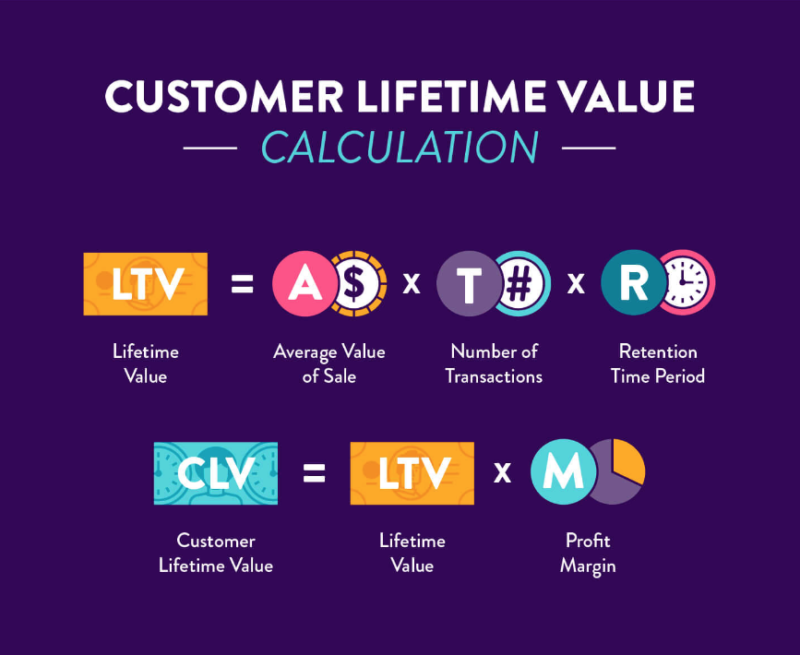
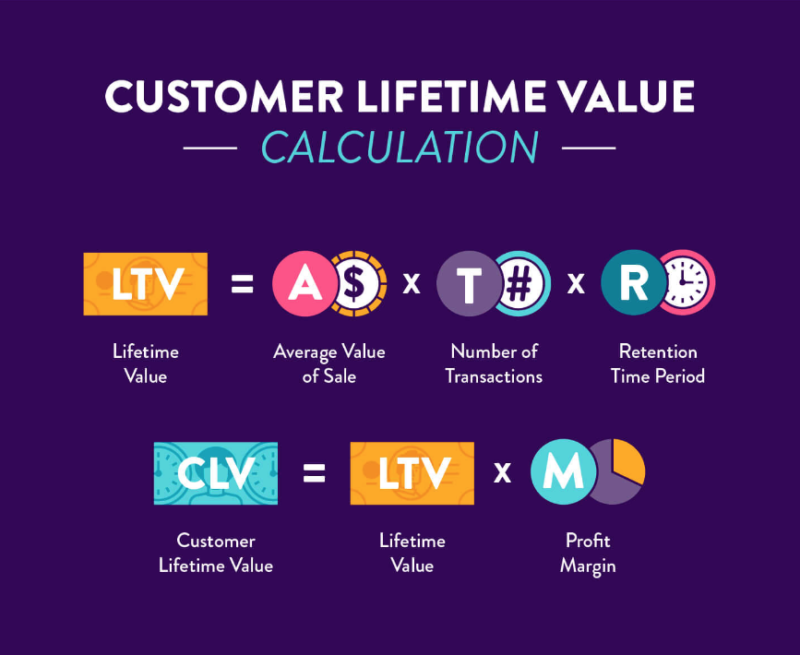

In [ ]:
 pip install lifetimes


In [ ]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = df_.copy()

In [ ]:

df["Country"].unique()

In [ ]:
df.describe().T

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]  

In [ ]:


df["TotalPrice"] = df["Quantity"] * df["Price"]


In [ ]:
today_date = dt.datetime(2011, 12, 11)

In [ ]:
# the difference from FRM to CLTV is we also checking the custom life value with first invoice to last invoice)
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [ ]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']


In [ ]:
cltv_df.head()

In [ ]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [ ]:
cltv_df = cltv_df[cltv_df["monetary"] > 0]

In [ ]:
# Expression of recency and T for BGNBD in weekly terms
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [ ]:
# frequency must be bigger then 1 
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

#### Establishment of BG-NBD Model

In [ ]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

#### Establishment of GAMMA- GAMMA Model

In [ ]:

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])


#### Calculation of CLTV with BG-NBD and GG model.

In [ ]:

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # for 6 months
                                   freq="W",  
                                   discount_rate=0.01)


In [ ]:
cltv.head()


In [ ]:

cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [ ]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

In [ ]:
# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1)) # verileri okunabilir hale getirme amaçlı
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])


In [ ]:
# sorting:
cltv_final.sort_values(by="scaled_clv", ascending=False).head()



In [ ]:
cltv_final_copy = cltv_final.copy()

Comment: It is predicted that the estimated profit that customer "18102" will get at the end of 6 months will be "85,651" unit

In [ ]:
###### CLTV for 1 Months #########

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  
                                   freq="W",  
                                   discount_rate=0.01)

In [ ]:
cltv.head()

In [ ]:
cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

In [ ]:

# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])


In [ ]:
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)

In [ ]:
###### CLTV for 12 Months #########

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  
                                   freq="W", 
                                   discount_rate=0.01)

cltv.head()

cltv = cltv.reset_index()
cltv.columns = ["Customer ID", "clv"]
cltv.sort_values(by="clv", ascending=False).head(50)
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

# Standardization of CLTV
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

# sorting:
cltv_final.sort_values(by="scaled_clv", ascending=False).head(10)